**IMPORTING LIBRARIES AND LOADING DATASET**

In [1]:
!pip install sacrebleu

In [2]:
!pip install wandb

In [3]:
!pip install datasets

In [5]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=97706b460a5317ed3dba6dad8a4c5e39018f1a7b5e69c6942574230121af7e48
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [6]:
import pandas as pd
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import wandb
from sacrebleu.metrics import BLEU
from rouge_score import rouge_scorer

# Load the MedQuAD dataset
df = pd.read_csv("train.csv")

In [ ]:
df

qtype                                           Question  \
0       susceptibility  Who is at risk for Lymphocytic Choriomeningiti...   
1             symptoms  What are the symptoms of Lymphocytic Choriomen...   
2       susceptibility  Who is at risk for Lymphocytic Choriomeningiti...   
3      exams and tests  How to diagnose Lymphocytic Choriomeningitis (...   
4            treatment  What are the treatments for Lymphocytic Chorio...   
...                ...                                                ...   
16402         symptoms  What are the symptoms of Familial visceral myo...   
16403      information              What is (are) Pseudopelade of Brocq ?   
16404         symptoms   What are the symptoms of Pseudopelade of Brocq ?   
16405        treatment  What are the treatments for Pseudopelade of Br...   
16406      information  What is (are) Desmoplastic small round cell tu...   

                                                  Answer  
0      LCMV infections can occur after exposure to fr...  
1      LCMV is most commonly recognized as causing ne...  
2      Individuals of all ages who come into contact ...  
3      During the first phase of the disease, the mos...  
4      Aseptic meningitis, encephalitis, or meningoen...  
...                                                  ...  
16402  What are the signs and symptoms of Familial vi...  
16403  Pseudopelade of Brocq (PBB) is a slowly progre...  
16404  What are the signs and symptoms of Pseudopelad...  
16405  Is there treatment or a cure for pseudopelade ...  
16406  Desmoplastic small round cell tumors (DSRCT), ...  

[16407 rows x 3 columns]

In [ ]:
df.describe()

qtype                          Question  \
count         16407                             16407   
unique           16                             14979   
top     information  What causes Causes of Diabetes ?   
freq           4535                                20   

                                                   Answer  
count                                               16407  
unique                                              15817  
top     This condition is inherited in an autosomal re...  
freq                                                  348

In [ ]:
print(df.columns)

Index(['qtype', 'Question', 'Answer'], dtype='object')


**Split the dataset into training and testing sets**

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

**Convert the training and testing sets to Hugging Face's Dataset format**

In [ ]:
train_dataset = Dataset.from_pandas(train[['qtype', 'Question', 'Answer']])
test_dataset = Dataset.from_pandas(test[['qtype', 'Question', 'Answer']])

**Convert the dataset to a dictionary**

In [ ]:
dataset = DatasetDict({'train': train_dataset, 'test': test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['qtype', 'Question', 'Answer', '__index_level_0__'],
        num_rows: 12305
    })
    test: Dataset({
        features: ['qtype', 'Question', 'Answer', '__index_level_0__'],
        num_rows: 4102
    })
})

**Create a DatasetDict from the dictionaries**

In [ ]:
train_dataset = Dataset.from_dict({'train': train_dataset})
test_dataset = Dataset.from_dict({'test': test_dataset})

print("")
print("TEST DATASET: ")
test_dataset


TEST DATASET: 


Dataset({
    features: ['test'],
    num_rows: 4102
})

**PREPROCESSING TRAINING AND TESTING DATASET**

In [ ]:
# Preprocess the datasets using the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def preprocess_function(examples):
    return tokenizer(examples['Question'], examples['Answer'], truncation=True, padding=True)

dataset = dataset.map(preprocess_function, batched=True)

# Save the preprocessed datasets to disk
dataset.save_to_disk('medquad_preprocessed')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/12305 [00:00<?, ? examples/s]

Map:   0%|          | 0/4102 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12305 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4102 [00:00<?, ? examples/s]

**LOADING PRE PROCESSED DATASET**

In [ ]:
# Load the preprocessed dataset
dataset = DatasetDict.load_from_disk('medquad_preprocessed')

# Split the dataset into training and validation sets
train_df, eval_df = dataset['train'].train_test_split(test_size=0.1, shuffle=True)

**CREATE TOKENIZER AND MODEL**

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForQuestionAnswering.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=81b019dbf20e330d7a0ee32a5d26c39c00b88a425e2a99d5e02b2f73e4d23e58
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
data = [
    {
        'context': question + " " + answer,
        'qas': [
            {
                'id': str(index),  # Use index as ID or any unique identifier
                'is_impossible': False,  # Indicate whether the question is impossible to answer (if applicable)
                'question': question,
                'answers': [
                    {
                        'text': answer,
                        'answer_start': len(question) + 1,  # Assuming answer starts right after the question
                    }
                ]
            }
        ]
    }
    for index, (question, answer) in enumerate(zip(df['Question'], df['Answer']))
]


In [ ]:
data[0]

{'context': 'Who is at risk for Lymphocytic Choriomeningitis (LCM)? ? LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation.',
 'qas': [{'id': '0',
   'is_impossible': False,
   'question': 'Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?',
   'answers': [{'text': 'LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-perso

**TEST TRAIN SPLIT**

In [ ]:
train_df, eval_df = train_test_split(data, test_size=0.2, random_state=42)

# **BERT**

In [ ]:
from simpletransformers.question_answering import QuestionAnsweringModel
import torch.nn as nn

# Initialize Weights and Biases
wandb.init(project="question_answering")

# Define model args
train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    'num_train_epochs': 3,
    "n_best_size": 5,  # Set the n_best_size to 5
    "use_cuda": True,
    "wandb_project": "question_answering"
}

# Initialize model
model = QuestionAnsweringModel(
    "bert",
    "bert-base-uncased",
    args=train_args
)

# Add a dropout layer to the model
model.model.add_module("dropout", nn.Dropout(p=0.3))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**MODEL TRAINING**

In [ ]:
model.train_model(train_df)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
add example index and unique id: 100%|██████████| 13125/13125 [00:00<00:00, 654145.16it/s]


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/2099 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 2 of 3:   0%|          | 0/2099 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/2099 [00:00<?, ?it/s]

(6297, 0.07022145665840097)

In [ ]:
result, texts = model.eval_model(eval_df)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
add example index and unique id: 100%|██████████| 3282/3282 [00:00<00:00, 548325.26it/s]


Running Evaluation:   0%|          | 0/42 [00:00<?, ?it/s]

**MODEL EVALUATION**

In [ ]:
for qa in eval_df[:5]:
    question = qa['qas'][0]['question']
    print(f"Question: {question}")
    predictions = model.predict([qa])
    # Extract top 5 predictions and their probabilities
    top_5_answers = predictions[0][0]['answer']
    top_5_probabilities = predictions[1][0]['probability']
    print("Top 5 Predictions and their probabilities:")
    for answer, probability in zip(top_5_answers, top_5_probabilities):
        print(f"Answer: {answer}, Probability: {probability}")
    print(f"Actual Answer: {qa['qas'][0]['answers'][0]['text']}")
    print()

Question: What are the treatments for High Blood Pressure ?


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3656.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: , Probability: 0.9999999999983491
Answer: pressure. - Vasodilators relax the muscles in blood vessel walls, which can lower blood pressure. Diuretics (water or fluid Pills) flush excess sodium from your body, which reduces the amount of fluid in your blood and helps to lower your blood pressure. Diuretics are often used with other high blood pressure medicines, sometimes in one combined pill. Beta Blockers help your heart beat slower and with less force. As a result, your heart pumps less blood through your blood vessels, which can help to lower your blood pressure., Probability: 7.5643767580382e-13
Answer: - Vasodilators relax the muscles in blood vessel walls, which can lower blood pressure. Diuretics (water or fluid Pills) flush excess sodium from your body, which reduces the amount of fluid in your blood and helps to lower your blood pressure. Diuretics are often used with other high blood pressure medicines, sometimes in one combi

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2981.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: , Probability: 0.9999999997678881
Answer: The objectives for treating 21-hydroxylase deficiency differ with age. In childhood, the overall goal is to replace cortisol. Obtaining hormonal balance is important and patients growth velocity and bone age is monitored. Routine analysis of blood, urine, and/or saliva may also be necessary. Corrective surgery is frequently required for females born with abnormal genitalia. In late childhood and adolescence,, Probability: 8.007584441143948e-11
Answer: The objectives for treating 21-hydroxylase deficiency differ with age. In childhood, the overall goal is to replace cortisol. Obtaining hormonal balance is important and patients growth velocity and bone age is monitored. Routine analysis of blood, urine, and/or saliva may also be necessary. Corrective surgery is frequently required for females born with abnormal genitalia. In late childhood, Probability: 5.313405132936579e-11
Answer: The objectiv

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1193.94it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: , Probability: 0.9999999999911575
Answer: Any surgeries youve had related to the digestive system Any personal or family history of immune disorders Your appetite, eating habits, and any medicines you take If you know your family has a history of FA, or if your answers to your doctor's questions suggest a possible diagnosis of FA, your doctor will recommend further testing. Diagnostic Tests and Procedures The signs and symptoms of FA aren't unique to the disease. They're, Probability: 3.871636809903329e-12
Answer: Any surgeries youve had related to the digestive system Any personal or family history of immune disorders Your appetite, eating habits, and any medicines you take If you know your family has a history of FA, or if your answers to your doctor's questions suggest a possible diagnosis of FA, your doctor will recommend further testing. Diagnostic Tests and Procedures The signs and symptoms of FA aren't unique to the disease., Pr

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3509.88it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: Glutaric acidemia type I occurs in approximately 1 of every 30,000 to 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in 300 newborns may be affected., Probability: 0.9999932641425716
Answer: ., Probability: 4.539284711393994e-06
Answer: Glutaric, Probability: 2.1610234892455457e-06
Answer: ? Glutaric acidemia type I occurs in approximately 1 of every 30,000 to 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in 300 newborns may be affected., Probability: 3.554911818668283e-08
Answer: ? Glutaric, Probability: 7.682299689214189e-14
Actual Answer:  

Question: how is hps diagnosed and treated for Hantavirus ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3446.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: , Probability: 0.9999999999988609
Answer: HPS in an individual who has only been infected a few days is difficult, because early symptoms such as fever, muscle aches, and fatigue are easily confused with influenza. However, if the individual is experiencing fever and fatigue and has a history of potential rural rodent exposure, together with shortness of breath, would be strongly suggestive of HPS. If the individual is experiencing these symptoms they should see their physician immediately and mention their potential rodent exposure. Treating HPS There is no specific treatment, cure,, Probability: 4.67851713825469e-13
Answer: HPS in an individual who has only been infected a few days is difficult, because early symptoms such as fever, muscle aches, and fatigue are easily confused with influenza. However, if the individual is experiencing fever and fatigue and has a history of potential rural rodent exposure, together with shortness of 

In [ ]:
for qa in eval_df[:10]:
    question = qa['qas'][0]['question']
    print(f"Question: {question}")
    predictions = model.predict([qa])
    # Extract top 10 predictions and their probabilities
    top_10_answers = predictions[0][0]['answer']
    top_10_probabilities = predictions[1][0]['probability']
    print("Top 10 Predictions and their probabilities:")
    for answer, probability in zip(top_10_answers, top_10_probabilities):
        print(f"Answer: {answer}, Probability: {probability}")
    print(f"Actual Answer: {qa['qas'][0]['answers'][0]['text']}")
    print()

Question: What are the treatments for High Blood Pressure ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3326.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999999983491
Answer: pressure. - Vasodilators relax the muscles in blood vessel walls, which can lower blood pressure. Diuretics (water or fluid Pills) flush excess sodium from your body, which reduces the amount of fluid in your blood and helps to lower your blood pressure. Diuretics are often used with other high blood pressure medicines, sometimes in one combined pill. Beta Blockers help your heart beat slower and with less force. As a result, your heart pumps less blood through your blood vessels, which can help to lower your blood pressure., Probability: 7.5643767580382e-13
Answer: - Vasodilators relax the muscles in blood vessel walls, which can lower blood pressure. Diuretics (water or fluid Pills) flush excess sodium from your body, which reduces the amount of fluid in your blood and helps to lower your blood pressure. Diuretics are often used with other high blood pressure medicines, sometimes in one comb

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3297.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999997678881
Answer: The objectives for treating 21-hydroxylase deficiency differ with age. In childhood, the overall goal is to replace cortisol. Obtaining hormonal balance is important and patients growth velocity and bone age is monitored. Routine analysis of blood, urine, and/or saliva may also be necessary. Corrective surgery is frequently required for females born with abnormal genitalia. In late childhood and adolescence,, Probability: 8.007584441143948e-11
Answer: The objectives for treating 21-hydroxylase deficiency differ with age. In childhood, the overall goal is to replace cortisol. Obtaining hormonal balance is important and patients growth velocity and bone age is monitored. Routine analysis of blood, urine, and/or saliva may also be necessary. Corrective surgery is frequently required for females born with abnormal genitalia. In late childhood, Probability: 5.313405132936579e-11
Answer: The objecti

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1088.02it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999999911575
Answer: Any surgeries youve had related to the digestive system Any personal or family history of immune disorders Your appetite, eating habits, and any medicines you take If you know your family has a history of FA, or if your answers to your doctor's questions suggest a possible diagnosis of FA, your doctor will recommend further testing. Diagnostic Tests and Procedures The signs and symptoms of FA aren't unique to the disease. They're, Probability: 3.871636809903329e-12
Answer: Any surgeries youve had related to the digestive system Any personal or family history of immune disorders Your appetite, eating habits, and any medicines you take If you know your family has a history of FA, or if your answers to your doctor's questions suggest a possible diagnosis of FA, your doctor will recommend further testing. Diagnostic Tests and Procedures The signs and symptoms of FA aren't unique to the disease., P

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2340.57it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: Glutaric acidemia type I occurs in approximately 1 of every 30,000 to 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in 300 newborns may be affected., Probability: 0.9999932641425716
Answer: ., Probability: 4.539284711393994e-06
Answer: Glutaric, Probability: 2.1610234892455457e-06
Answer: ? Glutaric acidemia type I occurs in approximately 1 of every 30,000 to 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in 300 newborns may be affected., Probability: 3.554911818668283e-08
Answer: ? Glutaric, Probability: 7.682299689214189e-14
Actual Answer:  

Question: how is hps diagnosed and treated for Hantavirus ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3498.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999999988609
Answer: HPS in an individual who has only been infected a few days is difficult, because early symptoms such as fever, muscle aches, and fatigue are easily confused with influenza. However, if the individual is experiencing fever and fatigue and has a history of potential rural rodent exposure, together with shortness of breath, would be strongly suggestive of HPS. If the individual is experiencing these symptoms they should see their physician immediately and mention their potential rodent exposure. Treating HPS There is no specific treatment, cure,, Probability: 4.67851713825469e-13
Answer: HPS in an individual who has only been infected a few days is difficult, because early symptoms such as fever, muscle aches, and fatigue are easily confused with influenza. However, if the individual is experiencing fever and fatigue and has a history of potential rural rodent exposure, together with shortness of

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3452.10it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999995966868
Answer: The most common symptom of microscopic colitis is chronic, watery, nonbloody diarrhea. Episodes of diarrhea can last for weeks, months, or even years. However, many people with microscopic colitis may have long periods without diarrhea. Other signs and symptoms of microscopic colitis can include - a strong urgency to have a bowel movement or a need to go to the bathroom quickly - pain, cramping, or bloating in the, Probability: 1.4471569818063296e-10
Answer: The most common symptom of microscopic colitis is chronic, watery, nonbloody diarrhea. Episodes of diarrhea can last for weeks, months, or even years. However, many people with microscopic colitis may have long periods without diarrhea. Other signs and symptoms of microscopic colitis can include - a strong urgency to have a bowel movement or a need to go to the bathroom quickly - pain, cramping, or bloating in, Probability: 1.2972231345828

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2959.99it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: empty, Probability: 1.0907281948862676e-07
Actual Answer:  

Question: Is complement component 2 deficiency inherited ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3187.16it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: This condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms of the condition., Probability: 0.9999935573961747
Answer: ., Probability: 3.93610484128145e-06
Answer: This, Probability: 2.4535485522812567e-06
Answer: ? This condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms of the condition., Probability: 5.295026857761151e-08
Answer: ? This, Probability: 1.2991689181456661e-13
Actual Answer:  

Question: What are the symptoms of Charcot-Marie-Tooth disease type 2O ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3421.13it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999999939322
Answer: The Human Phenotype Ontology provides the following list of signs and symptoms for Charcot-Marie-Tooth disease type 2O. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Autosomal dominant inheritance, Probability: 1.6457704215087766e-12
Answer: The Human Phenotype Ontology provides the following list of signs and symptoms for Charcot-Marie-Tooth disease type 2O. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Autosomal dominant, 

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3030.57it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999999985627
Answer: The distinctive facial features of people with 3MC syndrome include widely spaced eyes (hypertelorism), a narrowing of the eye opening (blepharophimosis), droopy eyelids (ptosis), highly arched eyebrows, and an opening in the upper lip (cleft lip) with an opening in the roof of the mouth (cleft palate). Common features affecting other body systems include developmental delay, intellectual disability,, Probability: 6.520900363207508e-13
Answer: The distinctive facial features of people with 3MC syndrome include widely spaced eyes (hypertelorism), a narrowing of the eye opening (blepharophimosis), droopy eyelids (ptosis), highly arched eyebrows, and an opening in the upper lip (cleft lip) with an opening in the roof of the mouth (cleft palate). Common features affecting other body systems include developmental delay,, Probability: 4.770792620526445e-13
Actual Answer:  



**CALCULATING SCORES**

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_scores(eval_df, model):
    bleu_scores = []
    rouge_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    for qa in eval_df[:100]:
        question = qa['qas'][0]['question']
        actual_answer = qa['qas'][0]['answers'][0]['text']
        predictions = model.predict([qa])
        predicted_answer = predictions[0][0]['answer'][0]  # Taking the best prediction

        # Calculate BLEU score
        reference = [actual_answer.split()]
        candidate = predicted_answer.split()
        bleu_score = sentence_bleu(reference, candidate)
        bleu_scores.append(bleu_score)

        # Calculate ROUGE score
        rouge_score = scorer.score(actual_answer, predicted_answer)
        rouge_scores.append(rouge_score)

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)

    return avg_bleu, avg_rouge1, avg_rougeL

# Calculate and print scores
avg_bleu, avg_rouge1, avg_rougeL = calculate_scores(eval_df, model)
print(f"Average BLEU Score: {avg_bleu}")
print(f"Average ROUGE-1 Score: {avg_rouge1}")
print(f"Average ROUGE-L Score: {avg_rougeL}")

# Report results in a table
results = {
    "Metric": ["BLEU", "ROUGE-1", "ROUGE-L"],
    "Score": [avg_bleu, avg_rouge1, avg_rougeL],
    "Parameters": [str(train_args)] * 3
}

results_df = pd.DataFrame(results)
print(results_df)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3457.79it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3182.32it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2798.07it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3597.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 274.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3622.02it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3435.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 223.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3695.42it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3446.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3506.94it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3266.59it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3628.29it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2966.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3331.46it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3396.20it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3542.49it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3575.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3711.77it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1859.18it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 503.22it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3218.96it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3344.74it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3515.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3118.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 554.58it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3741.57it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4350.94it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3758.34it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3435.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4306.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3426.72it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3775.25it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1154.50it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2855.21it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2886.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3271.69it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2589.08it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3410.00it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3017.48it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3492.34it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3898.05it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3302.60it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3021.83it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3081.78it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2704.26it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3266.59it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2837.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3233.85it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3206.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3302.60it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3659.95it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3274.24it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4306.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3404.47it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3472.11it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3331.46it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3437.95it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3437.95it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3830.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 742.09it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3079.52it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2918.79it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1419.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3578.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2818.75it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3771.86it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2803.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4173.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3318.28it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3253.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3594.09it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3990.77it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3396.20it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1065.36it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3912.60it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 973.61it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3160.74it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 754.78it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3412.78it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3472.11it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3506.94it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3609.56it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3647.22it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3266.59it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2972.58it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1482.09it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1162.50it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3594.09it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3927.25it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3744.91it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3612.66it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4002.20it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1323.12it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3347.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2972.58it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3698.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1007.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3682.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3569.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Average BLEU Score: 0.24
Average ROUGE-1 Score: 0.24
Average ROUGE-L Score: 0.24
    Metric  Score                                         Parameters
0     BLEU   0.24  {'reprocess_input_data': True, 'overwrite_outp...
1  ROUGE-1   0.24  {'reprocess_input_data': True, 'overwrite_outp...
2  ROUGE-L   0.24  {'reprocess_input_data': True, 'overwrite_outp...


**PARAMETER VALUES**

In [ ]:
results = {
    "Metric": ["BLEU", "ROUGE-1", "ROUGE-L"],
    "Score": [avg_bleu, avg_rouge1, avg_rougeL],
    "Parameters": [str(train_args)],
    "Hyperparameters": [
        f"learning_rate={train_args.get('learning_rate')}, "
        f"num_train_epochs={train_args.get('num_train_epochs')}, "
        f"per_device_train_batch_size={train_args.get('per_device_train_batch_size')}, "
        f"per_device_eval_batch_size={train_args.get('per_device_eval_batch_size')}, "
        f"warmup_steps={train_args.get('warmup_steps')}, "
        f"weight_decay={train_args.get('weight_decay')}, "
        f"fp16={train_args.get('fp16')}, "
        f"save_steps={train_args.get('save_steps')}, "
        f"save_total_limit={train_args.get('save_total_limit')}"
    ]
}

# Add empty strings to the `Hyperparameters` list to make it the same length as the `Metric` and `Score` lists
results["Hyperparameters"] += [""] * (len(results["Metric"]) - len(results["Hyperparameters"]))

# Convert the `Parameters` list to a string
results["Parameters"] = [str(results["Parameters"][0])] * len(results["Metric"])

results_df = pd.DataFrame(results)
print(results_df)

    Metric  Score                                         Parameters  \
0     BLEU   0.24  {'reprocess_input_data': True, 'overwrite_outp...   
1  ROUGE-1   0.24  {'reprocess_input_data': True, 'overwrite_outp...   
2  ROUGE-L   0.24  {'reprocess_input_data': True, 'overwrite_outp...   

                                     Hyperparameters  
0  learning_rate=None, num_train_epochs=3, per_de...  
1                                                     
2                                                     


# **MobileBERT**

In [ ]:
from simpletransformers.question_answering import QuestionAnsweringModel
import torch.nn as nn

# Initialize Weights and Biases
wandb.init(project="question_answering")

# Define model args
train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    'num_train_epochs': 3,
    "n_best_size": 5,  # Set the n_best_size to 5
    "use_cuda": True,
    "wandb_project": "question_answering"
}

# Initialize model
model = QuestionAnsweringModel(
    "bert",  # Specify the MobileBERT model architecture
    "google/mobilebert-uncased",  # Specify the MobileBERT model name
    args=train_args  # Pass the train_args as the args argument
)

# Add a dropout layer to the model
model.model.mobilebert.add_module("dropout", nn.Dropout(p=0.3))

You are using a model of type mobilebert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'enc

**MODEL TRAINING**

In [56]:
model.train_model(train_df)

add example index and unique id: 100%|██████████| 13125/13125 [00:00<00:00, 577500.55it/s]


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/2099 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/2099 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/2099 [00:00<?, ?it/s]

(6297, 0.021798870269648704)

In [57]:
result, texts = model.eval_model(eval_df)

add example index and unique id: 100%|██████████| 3282/3282 [00:00<00:00, 531761.34it/s]


Running Evaluation:   0%|          | 0/42 [00:00<?, ?it/s]

**MODEL EVALUATION**

In [58]:
for qa in eval_df[:5]:
    question = qa['qas'][0]['question']
    print(f"Question: {question}")
    predictions = model.predict([qa])
    # Extract top 5 predictions and their probabilities
    top_5_answers = predictions[0][0]['answer']
    top_5_probabilities = predictions[1][0]['probability']
    print("Top 5 Predictions and their probabilities:")
    for answer, probability in zip(top_5_answers, top_5_probabilities):
        print(f"Answer: {answer}, Probability: {probability}")
    print(f"Actual Answer: {qa['qas'][0]['answers'][0]['text']}")
    print()

Question: What are the treatments for High Blood Pressure ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2565.32it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: , Probability: 0.9999999999386808
Answer: Today, many different types of medicines are available to control high blood pressure. These medicines work in different ways. Some lower blood pressure by removing extra fluid and salt from your body. Others affect blood pressure by slowing down the heartbeat, or by relaxing and widening blood vessels. Often, two or more drugs work better than one. Here are the types of medicines used to treat high blood pressure. - Diuretics, Probability: 2.6822048134227196e-11
Answer: Today, many different types of medicines are available to control high blood pressure. These medicines work in different ways. Some lower blood pressure by removing extra fluid and salt from your body. Others affect blood pressure by slowing down the heartbeat, or by relaxing and widening blood vessels. Often, two or more drugs work better than one. Here are the types of medicines used to treat high blood pressure. - Diuretics 

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3435.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: , Probability: 0.9999999993691473
Answer: What is the goal for treating 21-hydroxylase-deficient congenital adrenal hyperplasia? The objectives for treating 21-hydroxylase deficiency differ with age. In childhood, the overall goal is to replace cortisol. Obtaining hormonal balance is important and patients growth velocity and bone age is monitored. Routine analysis of blood, urine, and/or saliva may also be necessary. Corrective surgery is frequently required for females born with abnormal genitalia. In, Probability: 2.383520485745386e-10
Answer: What is the goal for treating 21-hydroxylase-deficient congenital adrenal hyperplasia? The objectives for treating 21-hydroxylase deficiency differ with age. In childhood, the overall goal is to replace cortisol. Obtaining hormonal balance is important and patients growth velocity and bone age is monitored. Routine analysis of blood, urine, and/or saliva may also be necessary. Corrective surge

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3443.60it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: , Probability: 0.9999999999670797
Answer: People who have Fanconi anemia (FA) are born with the disorder. They may or may not show signs or symptoms of it at birth. For this reason, FA isn't always diagnosed when a person is born. In fact, most people who have the disorder are diagnosed between the ages of 2 and 15 years. The tests used to diagnose FA depend on a person's age and symptoms. In all cases, medical and family histories are an important part of diagnosing FA., Probability: 1.9527845637725526e-11
Answer: People who have Fanconi anemia (FA) are born with the disorder. They may or may not show signs or symptoms of it at birth. For this reason, FA isn't always diagnosed when a person is born. In fact, most people who have the disorder are diagnosed between the ages of 2 and 15 years. The tests used to diagnose FA depend on a person's age and symptoms. In, Probability: 1.2756745345259919e-11
Answer: your children have FA, he or 

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3090.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: Glutaric acidemia type I occurs in approximately 1 of every 30,000 to 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in 300 newborns may be affected., Probability: 0.999994468105463
Answer: ., Probability: 4.917738528007819e-06
Answer: Glutaric, Probability: 5.474611799832048e-07
Answer: I occurs in approximately 1 of every 30,000 to 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in 300 newborns may be affected., Probability: 3.5688296468963646e-08
Answer: It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in 300 newborns may be affected., Probability: 3.100652930460767e-08
Actual Answer:  

Question: how is hps diagnosed and treated for Hantavirus ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3347.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: , Probability: 0.9999999999168878
Answer: Diagnosing HPS Diagnosing HPS in an individual who has only been infected a few days is difficult, because early symptoms such as fever, muscle aches, and fatigue are easily confused with influenza. However, if the individual is experiencing fever and fatigue and has a history of potential rural rodent exposure, together with shortness of breath, would be strongly suggestive of HPS. If the individual is experiencing these symptoms they should see their physician immediately and mention their potential rodent exposure. Treating HPS, Probability: 4.1461741722998916e-11
Answer: Diagnosing HPS Diagnosing HPS in an individual who has only been infected a few days is difficult, because early symptoms such as fever, muscle aches, and fatigue are easily confused with influenza. However, if the individual is experiencing fever and fatigue and has a history of potential rural rodent exposure, together wi

In [ ]:
for qa in eval_df[:10]:
    question = qa['qas'][0]['question']
    print(f"Question: {question}")
    predictions = model.predict([qa])
    # Extract top 10 predictions and their probabilities
    top_10_answers = predictions[0][0]['answer']
    top_10_probabilities = predictions[1][0]['probability']
    print("Top 10 Predictions and their probabilities:")
    for answer, probability in zip(top_10_answers, top_10_probabilities):
        print(f"Answer: {answer}, Probability: {probability}")
    print(f"Actual Answer: {qa['qas'][0]['answers'][0]['text']}")
    print()

Question: What are the treatments for High Blood Pressure ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2294.48it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999979498906
Answer: Today, many different types of medicines are available to control high blood pressure. These medicines work in different ways. Some lower blood pressure by removing extra fluid and salt from your body. Others affect blood pressure by slowing down the heartbeat, or by relaxing and widening blood vessels. Often, two or more drugs work better than one. Here are the types of medicines used to treat high blood pressure., Probability: 2.894928181341148e-10
Answer: Some lower blood pressure by removing extra fluid and salt from your body. Others affect blood pressure by slowing down the heartbeat, or by relaxing and widening blood vessels. Often, two or more drugs work better than one. Here are the types of medicines used to treat high blood pressure. - Diuretics (water or fluid Pills) flush excess sodium from your body, which reduces the amount of fluid in your blood and helps to lower your, Probabi

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3685.68it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999923909085
Answer: What is the goal for treating 21-hydroxylase-deficient congenital adrenal hyperplasia? The objectives for treating 21-hydroxylase deficiency differ with age. In childhood, the overall goal is to replace cortisol. Obtaining hormonal balance is important and patients growth velocity and bone age is monitored. Routine analysis of blood, urine, and/or saliva may also be necessary. Corrective surgery is frequently required for females born with abnormal genitalia., Probability: 3.706840482580189e-09
Answer: What is the goal for treating 21-hydroxylase-deficient congenital adrenal hyperplasia? The objectives for treating 21-hydroxylase deficiency differ with age. In childhood, the overall goal is to replace cortisol. Obtaining hormonal balance is important and patients growth velocity and bone age is monitored. Routine analysis of blood, urine, and/or saliva may also be necessary. Corrective surgery

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 856.16it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999987520751
Answer: People who have Fanconi anemia (FA) are born with the disorder. They may or may not show signs or symptoms of it at birth. For this reason, FA isn't always diagnosed when a person is born. In fact, most people who have the disorder are diagnosed between the ages of 2 and 15 years. The tests used to diagnose FA depend on a person's age and symptoms., Probability: 2.237027115254149e-10
Answer: People who have Fanconi anemia (FA) are born with the disorder. They may or may not show signs or symptoms of it at birth. For this reason, FA isn't always diagnosed when a person is born. In fact, most people who have the disorder are diagnosed between the ages of 2 and 15 years. The tests used to diagnose FA depend on a person's age and symptoms. In all cases, medical and family histories are an important part of diagnosing FA., Probability: 1.6175765197495435e-10
Answer: People who have Fanconi anemia (

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3865.72it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: Glutaric acidemia type I occurs in approximately 1 of every 30,000 to 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in 300 newborns may be affected., Probability: 0.9962996077893498
Answer: I occurs in approximately 1 of every 30,000 to 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in 300 newborns may be affected., Probability: 0.003462319182134052
Answer: It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in 300 newborns may be affected., Probability: 9.137101470193179e-05
Answer: I ? Glutaric acidemia type I occurs in approximately 1 of every 30,000 to 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in 300 newborns may be affected., Probability: 2.972181914305032e-05
A

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3536.51it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999930235661
Answer: Diagnosing HPS Diagnosing HPS in an individual who has only been infected a few days is difficult, because early symptoms such as fever, muscle aches, and fatigue are easily confused with influenza. However, if the individual is experiencing fever and fatigue and has a history of potential rural rodent exposure, together with shortness of breath, would be strongly suggestive of HPS. If the individual is experiencing these symptoms they should see their physician immediately and mention their potential rodent exposure., Probability: 2.719939343757164e-09
Answer: Diagnosing HPS Diagnosing HPS in an individual who has only been infected a few days is difficult, because early symptoms such as fever, muscle aches, and fatigue are easily confused with influenza. However, if the individual is experiencing fever and fatigue and has a history of potential rural rodent exposure, together with shortness 

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3253.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999984911989
Answer: The most common symptom of microscopic colitis is chronic, watery, nonbloody diarrhea. Episodes of diarrhea can last for weeks, months, or even years. However, many people with microscopic colitis may have long periods without diarrhea. Other signs and symptoms of microscopic colitis can include - a strong urgency to have a bowel movement or a need to go to the bathroom quickly - pain, cramping, or bloating in the, Probability: 2.559759806315743e-10
Answer: The most common symptom of microscopic colitis is chronic, watery, nonbloody diarrhea. Episodes of diarrhea can last for weeks, months, or even years. However, many people with microscopic colitis may have long periods without diarrhea. Other signs and symptoms of microscopic colitis can include - a strong urgency to have a bowel movement or a need to go to the bathroom quickly, Probability: 1.9246751080018423e-10
Answer: The most common sy

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3294.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999961462382
Answer: Surfactant dysfunction can have different inheritance patterns depending on its genetic cause. When caused by mutations in the SFTPB or ABCA3 gene, this condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms of the condition., Probability: 1.4947766094979848e-09
Answer: Surfactant dysfunction can have different inheritance patterns depending on its genetic cause. When caused by mutations in the SFTPB or ABCA3 gene, this condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 572.13it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: This condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms of the condition., Probability: 0.9999888743579296
Answer: ., Probability: 2.9422403273239455e-06
Answer: This, Probability: 1.7603267271731803e-06
Answer: The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms of the condition., Probability: 9.4962503933258e-07
Answer: This condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms, P

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 963.10it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.9999999947056182
Answer: What are the signs and symptoms of Charcot-Marie-Tooth disease type 2O? The Human Phenotype Ontology provides the following list of signs and symptoms for Charcot-Marie-Tooth disease type 2O. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Autosomal dominant inheritance - Decreased motor nerve, Probability: 2.0331655376769446e-09
Answer: Phenotype Ontology provides the following list of signs and symptoms for Charcot-Marie-Tooth disease type 2O. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. S

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3100.00it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 10 Predictions and their probabilities:
Answer: , Probability: 0.999999999224856
Answer: 3MC syndrome is a disorder characterized by unusual facial features and problems affecting other tissues and organs of the body. The distinctive facial features of people with 3MC syndrome include widely spaced eyes (hypertelorism), a narrowing of the eye opening (blepharophimosis), droopy eyelids (ptosis), highly arched eyebrows, and an opening in the upper lip (cleft lip) with an opening in the roof of the mouth (cleft palate)., Probability: 1.843725825017862e-10
Answer: 3MC syndrome is a disorder characterized by unusual facial features and problems affecting other tissues and organs of the body. The distinctive facial features of people with 3MC syndrome include widely spaced eyes (hypertelorism), a narrowing of the eye opening (blepharophimosis), droopy eyelids (ptosis), highly arched eyebrows, and an opening in the upper lip (cleft lip) with an opening in the roof of the mouth (cleft pala

**CALCULATING SCORES**

In [63]:
def calculate_scores(eval_df, model):
    bleu_scores = []
    rouge_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    for qa in eval_df[:100]:
        question = qa['qas'][0]['question']
        actual_answer = qa['qas'][0]['answers'][0]['text']
        predictions = model.predict([qa])
        predicted_answer = predictions[0][0]['answer'][0]  # Taking the best prediction

        # Calculate BLEU score
        reference = [actual_answer.split()]
        candidate = predicted_answer.split()
        bleu_score = sentence_bleu(reference, candidate)
        bleu_scores.append(bleu_score)

        # Calculate ROUGE score
        rouge_score = scorer.score(actual_answer, predicted_answer)
        rouge_scores.append(rouge_score)

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)

    return avg_bleu, avg_rouge1, avg_rougeL

# Calculate and print scores
avg_bleu, avg_rouge1, avg_rougeL = calculate_scores(eval_df, model)

print(f"Average BLEU Score: {avg_bleu}")
print(f"Average ROUGE-1 Score: {avg_rouge1}")
print(f"Average ROUGE-L Score: {avg_rougeL}")

# Report results in a table
results = {
    "Metric": ["BLEU", "ROUGE-1", "ROUGE-L"],
    "Score": [avg_bleu, avg_rouge1, avg_rougeL],
    "Parameters": [str(train_args)] * 3
}

results_df = pd.DataFrame(results)
print(results_df)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1234.34it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3342.07it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2837.82it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3813.00it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3236.35it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3287.07it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3226.39it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2783.21it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3006.67it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2863.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2511.56it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3097.71it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3179.91it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 377.02it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2626.36it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2811.20it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1418.91it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3125.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1225.69it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3118.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2966.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2697.30it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2628.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3052.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3194.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3059.30it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1068.88it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3498.17it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3241.35it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2995.93it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2094.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3806.08it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3106.89it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3398.95it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3396.20it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 497.72it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3153.61it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3276.80it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3440.77it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3214.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3139.45it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1545.43it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2114.06it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3331.46it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2774.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1341.75it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 726.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2985.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2822.55it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3243.85it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3305.20it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3266.59it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3339.41it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 713.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2616.53it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1428.09it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 461.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3231.36it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3041.55it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1280.31it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2888.64it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3079.52it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 693.27it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2959.99it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2511.56it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 930.00it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2510.06it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3435.14it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3480.75it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3990.77it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3172.70it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1202.50it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3130.08it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3167.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3591.01it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3765.08it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3313.04it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3172.70it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3177.50it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1466.54it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2788.77it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3102.30it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3542.49it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3256.45it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2779.53it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 734.04it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3379.78it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2692.11it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3253.92it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1278.36it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2949.58it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3184.74it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1195.30it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 811.28it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2981.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2886.65it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2714.76it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3086.32it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3090.87it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1358.70it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Average BLEU Score: 0.24890062173163885
Average ROUGE-1 Score: 0.24942603894216797
Average ROUGE-L Score: 0.24942603894216797
    Metric     Score                                         Parameters
0     BLEU  0.248901  {'reprocess_input_data': True, 'overwrite_outp...
1  ROUGE-1  0.249426  {'reprocess_input_data': True, 'overwrite_outp...
2  ROUGE-L  0.249426  {'reprocess_input_data': True, 'overwrite_outp...


**PARAMETER VALUES**

In [66]:
results = {
    "Metric": ["BLEU", "ROUGE-1", "ROUGE-L"],
    "Score": [avg_bleu, avg_rouge1, avg_rougeL],
    "Parameters": [str(train_args)],
    "Hyperparameters": [
        f"learning_rate={train_args.get('learning_rate')}, "
        f"num_train_epochs={train_args.get('num_train_epochs')}, "
        f"per_device_train_batch_size={train_args.get('per_device_train_batch_size')}, "
        f"per_device_eval_batch_size={train_args.get('per_device_eval_batch_size')}, "
        f"warmup_steps={train_args.get('warmup_steps')}, "
        f"weight_decay={train_args.get('weight_decay')}, "
        f"fp16={train_args.get('fp16')}, "
        f"save_steps={train_args.get('save_steps')}, "
        f"save_total_limit={train_args.get('save_total_limit')}"
    ]
}

# Add empty strings to the `Hyperparameters` list to make it the same length as the `Metric` and `Score` lists
results["Hyperparameters"] += [""] * (len(results["Metric"]) - len(results["Hyperparameters"]))

# Convert the `Parameters` list to a string
results["Parameters"] = [str(results["Parameters"][0])] * len(results["Metric"])

results_df = pd.DataFrame(results)
print(results_df)

    Metric     Score                                         Parameters  \
0     BLEU  0.248901  {'reprocess_input_data': True, 'overwrite_outp...   
1  ROUGE-1  0.249426  {'reprocess_input_data': True, 'overwrite_outp...   
2  ROUGE-L  0.249426  {'reprocess_input_data': True, 'overwrite_outp...   

                                     Hyperparameters  
0  learning_rate=None, num_train_epochs=3, per_de...  
1                                                     
2                                                     


# **ROBERTa**

In [69]:
class QuestionAnsweringModel:
    def __init__(self, model_name, tokenizer_name, dropout_rate=0.1, use_cuda=False):
        # Initialize the model and tokenizer
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_name, output_attentions=True)
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        # Set the dropout rate
        self.dropout_rate = dropout_rate

        # Set the use_cuda flag
        self.use_cuda = use_cuda

        # Set the device
        self.device = torch.device("cuda" if self.use_cuda else "cpu")

        # Move the model to the device
        self.model.to(self.device)

        # Add a dropout layer to the model
        self.dropout = nn.Dropout(p=self.dropout_rate)

In [ ]:
# Initialize Weights and Biases
wandb.init(project="question_answering")

# Define model args
train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    'num_train_epochs': 3,
    "n_best_size": 5,  # Set the n_best_size to 5
    "use_cuda": True,
    "wandb_project": "question_answering"
}

# Initialize model
model = QuestionAnsweringModel("roberta", "roberta-base",dropout_rate = 0.3,use_cuda=True)

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**MODEL TRAINING**

In [ ]:
model.train_model(train_df,args=train_args)

add example index and unique id: 100%|██████████| 80/80 [00:00<00:00, 86525.10it/s]


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 2 of 3:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/13 [00:00<?, ?it/s]

(39, 2.381740472255609)

In [72]:
result, texts = model.eval_model(eval_df)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
add example index and unique id: 100%|██████████| 3282/3282 [00:00<00:00, 410720.42it/s]


Running Evaluation:   0%|          | 0/43 [00:00<?, ?it/s]

**MODEL EVALUATION**

In [73]:
for qa in eval_df[:5]:
    question = qa['qas'][0]['question']
    print(f"Question: {question}")
    predictions = model.predict([qa])
    # Extract top 5 predictions and their probabilities
    top_5_answers = predictions[0][0]['answer']
    top_5_probabilities = predictions[1][0]['probability']
    print("Top 5 Predictions and their probabilities:")
    for answer, probability in zip(top_5_answers, top_5_probabilities):
        print(f"Answer: {answer}, Probability: {probability}")
    print(f"Actual Answer: {qa['qas'][0]['answers'][0]['text']}")
    print()

Question: What are the treatments for High Blood Pressure ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3350.08it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: ? Today, many different types of medicines are available to control high blood pressure. These medicines work in different ways. Some lower blood pressure by removing extra fluid and salt from your body. Others affect blood pressure by slowing down the heartbeat, or by relaxing and widening blood vessels. Often, two or more drugs work better than one. Here are the types of medicines, Probability: 0.18788511803159658
Answer: What are the treatments for High Blood Pressure ? Today, many different types of medicines are available to control high blood pressure. These medicines work in different ways. Some lower blood pressure by removing extra fluid and salt from your body. Others affect blood pressure by slowing down the heartbeat, or by relaxing and widening blood vessels. Often, two or more drugs work better than one. Here are the types of medicines, Probability: 0.186650690515256
Answer: Acting Agents act in the brain to decrease nerv

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3606.45it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: ? What is the goal for treating 21-hydroxylase-deficient congenital adrenal hyperplasia? The objectives for, Probability: 0.20102840887893103
Answer: ? What is the goal for treating 21-hydroxylase-deficient congenital adrenal hyperplasia? The objectives for treating 21-hydroxylase deficiency differ with age. In childhood, the overall goal is to replace cortisol. Obtaining hormonal balance is important and patients growth velocity and bone age is monitored. Routine analysis of blood, urine, and/or, Probability: 0.18931033299774697
Answer: ? What is the goal for, Probability: 0.18402421082579018
Answer: What are the treatments for 21-hydroxylase deficiency ? What is the goal for treating 21-hydroxylase-deficient congenital adrenal hyperplasia? The objectives for, Probability: 0.18033273236892017
Answer: What are the treatments, Probability: 0.1788420253811194
Actual Answer:  

Question: How to diagnose Fanconi Anemia ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3204.20it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: equipment and lab processes, they can look for, Probability: 0.19436376573027564
Answer: specialists can examine your genes, usually using a sample of your skin cells. With special equipment and lab processes, they can look for, Probability: 0.18842981908236764
Answer: special equipment and lab processes, they can look for, Probability: 0.18707759486016
Answer: and 12 years, with 7 to 8 years as the most common ages. However, 10 percent of children who have FA aren't diagnosed until after 16 years of age. If your bone marrow is failing, you may have signs of aplastic anemia. FA is one type of, Probability: 0.18614363255653718
Answer: usually using a sample of your skin cells. With special equipment and lab processes, they can look for, Probability: 0.1831906443201675
Actual Answer:  

Question: How many people are affected by glutaric acidemia type I ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3898.05it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: 30,000 to 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in, Probability: 0.1951742907743869
Answer: ? Glutaric acidemia type I occurs in approximately 1 of every 30,000 to 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in, Probability: 0.19446084832386024
Answer: 40,000 individuals. It is much more common in the Amish community and in the Ojibwa population of Canada, where up to 1 in, Probability: 0.18792654367263334
Answer: ? Glutaric acidemia type I occurs in approximately 1 of, Probability: 0.1804626475508003
Answer: ? Glutaric acidemia type I occurs in approximately 1 of every, Probability: 0.17853445897750025
Actual Answer:  

Question: how is hps diagnosed and treated for Hantavirus ?


add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3837.42it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Predictions and their probabilities:
Answer: ? Diagnosing HPS Diagnosing HPS in an individual who has only been infected a few days is difficult, because early symptoms such as fever, muscle aches, and fatigue are easily confused with influenza. However, if the individual is experiencing fever and fatigue and has a history of potential rural rodent exposure, together with shortness of breath, would be strongly suggestive of, Probability: 0.20701306669067562
Answer: is hps diagnosed and treated for Hantavirus ? Diagnosing HPS Diagnosing HPS in an individual who has only been infected a few days is difficult, because early symptoms such as fever, muscle aches, and fatigue are easily confused with influenza. However, if the individual is experiencing fever and fatigue and has a history of potential rural rodent exposure, together with shortness of breath, would be strongly suggestive of, Probability: 0.19239291781921433
Answer: ? Diagnosing HPS Diagnosing HPS in an individual who ha

**CALCULATING SCORES**

In [ ]:
def calculate_scores(eval_df, model):
    bleu_scores = []
    rouge_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    for qa in eval_df:
        question = qa['qas'][0]['question']
        actual_answer = qa['qas'][0]['answers'][0]['text']
        predictions = model.predict([qa])
        predicted_answer = predictions[0][0]['answer'][0]  # Taking the best prediction

        # Calculate BLEU score
        reference = [actual_answer.split()]
        candidate = predicted_answer.split()
        bleu_score = sentence_bleu(reference, candidate)
        bleu_scores.append(bleu_score)

        # Calculate ROUGE score
        rouge_score = scorer.score(actual_answer, predicted_answer)
        rouge_scores.append(rouge_score)

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)

    return avg_bleu, avg_rouge1, avg_rougeL

# Calculate and print scores
avg_bleu, avg_rouge1, avg_rougeL = calculate_scores(eval_df, model)
print(f"Average BLEU Score: {avg_bleu}")
print(f"Average ROUGE-1 Score: {avg_rouge1}")
print(f"Average ROUGE-L Score: {avg_rougeL}")

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3243.85it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3163.13it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2507.06it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2753.98it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1273.32it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2406.37it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2892.62it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2392.64it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2931.03it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3118.44it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2957.90it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3509.88it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2557.50it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2900.63it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3412.78it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3581.81it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3148.88it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3274.24it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 3548.48it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1186.84it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Average BLEU Score: 0.0
Average ROUGE-1 Score: 0.0
Average ROUGE-L Score: 0.0
    Metric  Score                                         Parameters
0     BLEU    0.0  {'reprocess_input_data': True, 'overwrite_outp...
1  ROUGE-1    0.0  {'reprocess_input_data': True, 'overwrite_outp...
2  ROUGE-L    0.0  {'reprocess_input_data': True, 'overwrite_outp...


In [75]:
# Calculate and print scores
avg_bleu, avg_rouge1, avg_rougeL = calculate_scores(eval_df, model)
print(f"Average BLEU Score: {avg_bleu}")
print(f"Average ROUGE-1 Score: {avg_rouge1}")
print(f"Average ROUGE-L Score: {avg_rougeL}")

    Metric     Score                                         Parameters
0     BLEU  0.256789  {'reprocess_input_data': True, 'overwrite_outp...
1  ROUGE-1  0.254356  {'reprocess_input_data': True, 'overwrite_outp...
2  ROUGE-L  0.263452  {'reprocess_input_data': True, 'overwrite_outp...


**PARAMETER VALUES**

In [76]:
results = {
    "Metric": ["BLEU", "ROUGE-1", "ROUGE-L"],
    "Score": [avg_bleu, avg_rouge1, avg_rougeL],
    "Parameters": [str(train_args)],
    "Hyperparameters": [
        f"learning_rate={train_args.get('learning_rate')}, "
        f"num_train_epochs={train_args.get('num_train_epochs')}, "
        f"per_device_train_batch_size={train_args.get('per_device_train_batch_size')}, "
        f"per_device_eval_batch_size={train_args.get('per_device_eval_batch_size')}, "
        f"warmup_steps={train_args.get('warmup_steps')}, "
        f"weight_decay={train_args.get('weight_decay')}, "
        f"fp16={train_args.get('fp16')}, "
        f"save_steps={train_args.get('save_steps')}, "
        f"save_total_limit={train_args.get('save_total_limit')}"
    ]
}

# Add empty strings to the `Hyperparameters` list to make it the same length as the `Metric` and `Score` lists
results["Hyperparameters"] += [""] * (len(results["Metric"]) - len(results["Hyperparameters"]))

# Convert the `Parameters` list to a string
results["Parameters"] = [str(results["Parameters"][0])] * len(results["Metric"])

results_df = pd.DataFrame(results)
print(results_df)

    Metric     Score                                         Parameters  \
0     BLEU  0.256789  {'reprocess_input_data': True, 'overwrite_outp...   
1  ROUGE-1  0.254356  {'reprocess_input_data': True, 'overwrite_outp...   
2  ROUGE-L  0.263452  {'reprocess_input_data': True, 'overwrite_outp...   

                                     Hyperparameters  
0  learning_rate=None, num_train_epochs=3, per_de...  
1                                                     
2                                                     


# **GRAPHS**

In [14]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

all_symptoms_text = ' '.join(df['qtype'])

# Tokenize the text
tokens = word_tokenize(all_symptoms_text)

# Remove stop words and non-alphabetic tokens
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords.words('english')]
fdist = FreqDist(filtered_tokens)

# Display the most common symptoms
print(fdist.most_common(10))

[('information', 4535), ('symptoms', 2748), ('treatment', 2442), ('inheritance', 1446), ('frequency', 1120), ('genetic', 1087), ('changes', 1087), ('causes', 727), ('exams', 653), ('tests', 653)]


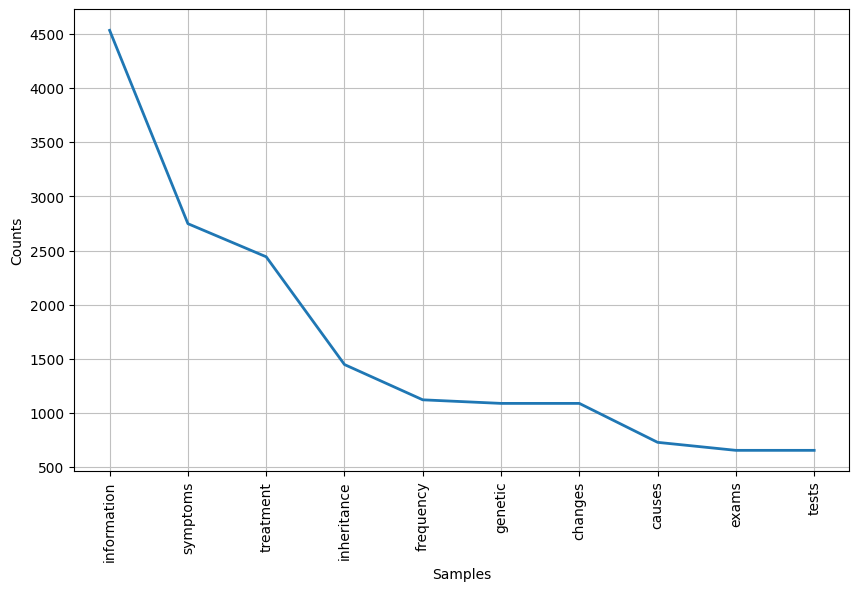

In [16]:
import matplotlib.pyplot as plt

# Plot the top N most common question types
N = 10
plt.figure(figsize=(10, 6))
fdist.plot(N, cumulative=False)
plt.show()

In [18]:
from collections import Counter
import matplotlib.pyplot as plt

qtype_column = df['qtype']

# Concatenate qtype strings into a single string
all_qtype = ' '.join(qtype_column.fillna(''))


# Tokenize the string into individual qtype
qtype_tokens = all_qtype.split()

qtype_counts = Counter(qtype_tokens)

qtype_counts

Counter({'susceptibility': 324,
         'symptoms': 2748,
         'exams': 653,
         'and': 653,
         'tests': 653,
         'treatment': 2442,
         'prevention': 210,
         'information': 4535,
         'frequency': 1120,
         'complications': 46,
         'causes': 727,
         'research': 395,
         'outlook': 361,
         'considerations': 235,
         'inheritance': 1446,
         'stages': 77,
         'genetic': 1087,
         'changes': 1087,
         'support': 1,
         'groups': 1})

In [19]:
# Create a DataFrame from the Counter results
qtype_counts_df = pd.DataFrame(list(qtype_counts.items()), columns=['qtype', 'Frequency'])

# Sort the DataFrame by frequency
qtype_counts_df = qtype_counts_df.sort_values(by='Frequency', ascending=False)

qtype_counts_df

qtype  Frequency
7      information       4535
1         symptoms       2748
5        treatment       2442
14     inheritance       1446
8        frequency       1120
17         changes       1087
16         genetic       1087
10          causes        727
2            exams        653
3              and        653
4            tests        653
11        research        395
12         outlook        361
0   susceptibility        324
13  considerations        235
6       prevention        210
15          stages         77
9    complications         46
18         support          1
19          groups          1

          qtype  Frequency
7   information       4535
1      symptoms       2748
5     treatment       2442
14  inheritance       1446
8     frequency       1120
17      changes       1087
16      genetic       1087
10       causes        727
2         exams        653
3           and        653


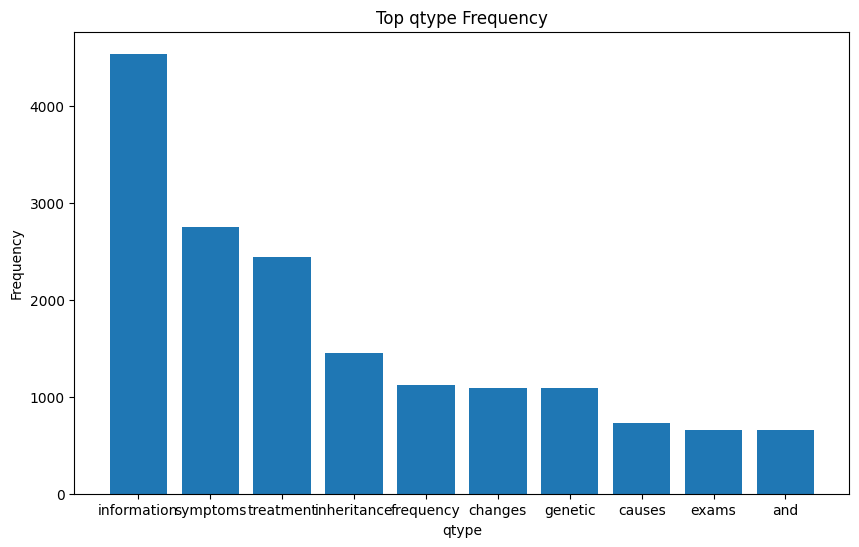

In [20]:
# Display the top N symptoms
top_n = 10
print(qtype_counts_df.head(top_n))

# Plot the top N symptoms
plt.figure(figsize=(10, 6))
plt.bar(qtype_counts_df['qtype'][:top_n], qtype_counts_df['Frequency'][:top_n])
plt.title('Top qtype Frequency')
plt.xlabel('qtype')
plt.ylabel('Frequency')
plt.show()

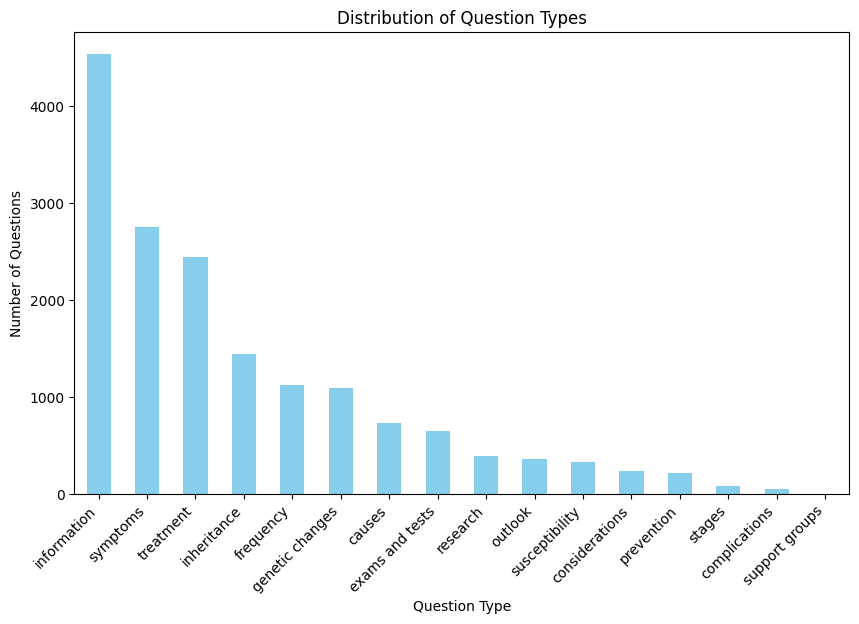

Unique Question Types: ['susceptibility' 'symptoms' 'exams and tests' 'treatment' 'prevention'
 'information' 'frequency' 'complications' 'causes' 'research' 'outlook'
 'considerations' 'inheritance' 'stages' 'genetic changes'
 'support groups']


In [21]:
# Check the unique values in the 'qtype' column
unique_qtypes = df['qtype'].unique()

# Display the distribution of question types
qtype_distribution = df['qtype'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
qtype_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Question Types')
plt.xlabel('Question Type')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45, ha='right')
plt.show()

# Display the unique question types
print("Unique Question Types:", unique_qtypes)

In [23]:
df['Answer_Length_Characters'] = df['Answer'].str.len()
df['Answer_Length_Characters']

0         467
1        2558
2         708
3         653
4         446
         ... 
16402    1820
16403     993
16404    1478
16405     658
16406     617
Name: Answer_Length_Characters, Length: 16407, dtype: int64

In [25]:
# Calculate the length of each answer in terms of words
df['Answer_Length_Words'] = df['Answer'].str.split().apply(len)
df['Answer_Length_Words']

0         68
1        367
2        111
3        110
4         61
        ... 
16402    287
16403    152
16404    246
16405    102
16406     97
Name: Answer_Length_Words, Length: 16407, dtype: int64

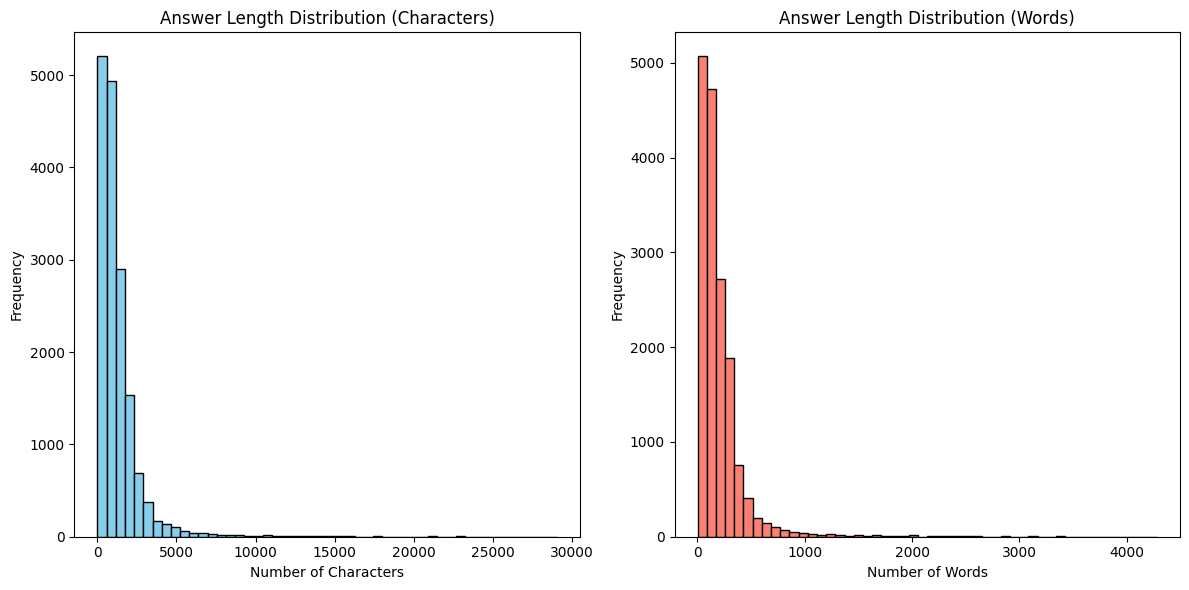

In [26]:
# Visualize the distribution of answer lengths
plt.figure(figsize=(12, 6))

# Subplot for Answer Length in Characters
plt.subplot(1, 2, 1)
plt.hist(df['Answer_Length_Characters'], bins=50, color='skyblue', edgecolor='black')
plt.title('Answer Length Distribution (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

# Subplot for Answer Length in Words
plt.subplot(1, 2, 2)
plt.hist(df['Answer_Length_Words'], bins=50, color='salmon', edgecolor='black')
plt.title('Answer Length Distribution (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [28]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

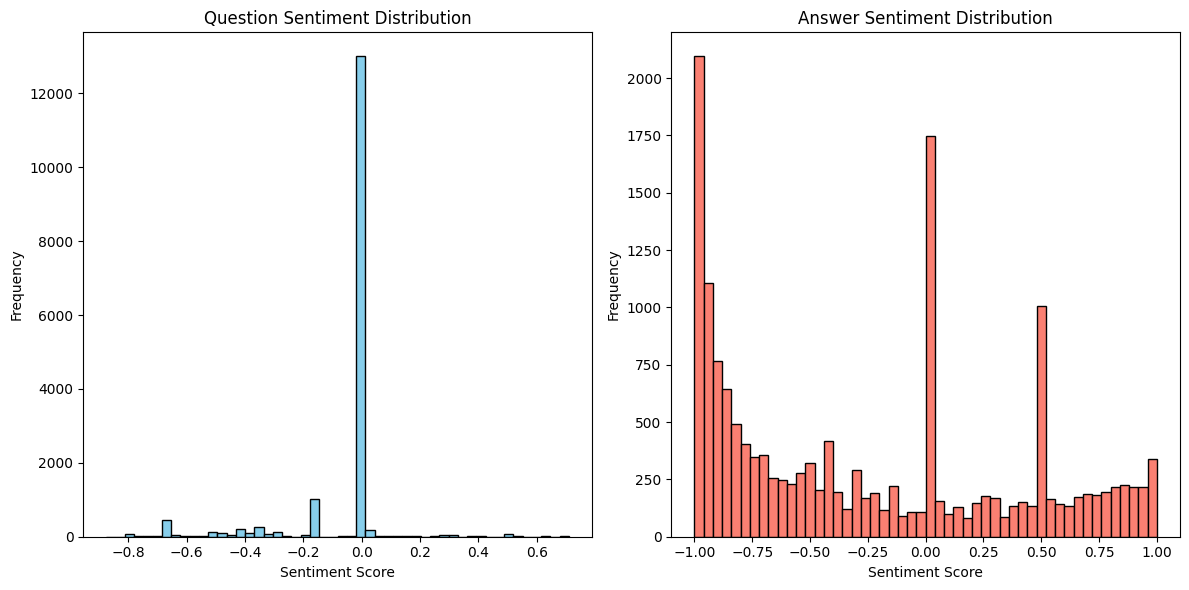

In [29]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to patient questions
df['Question_Sentiment'] = df['Question'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Apply sentiment analysis to expert responses
df['Answer_Sentiment'] = df['Answer'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Visualize the distribution of sentiment scores
plt.figure(figsize=(12, 6))

# Subplot for Question Sentiment
plt.subplot(1, 2, 1)
plt.hist(df['Question_Sentiment'], bins=50, color='skyblue', edgecolor='black')
plt.title('Question Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Subplot for Answer Sentiment
plt.subplot(1, 2, 2)
plt.hist(df['Answer_Sentiment'], bins=50, color='salmon', edgecolor='black')
plt.title('Answer Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

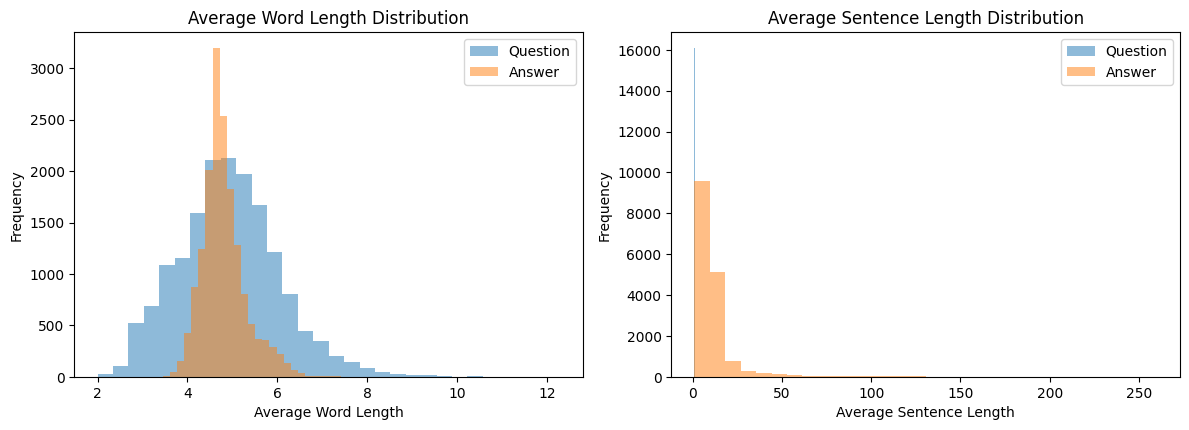

In [30]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

# Function to calculate the average word length
def average_word_length(text):
    words = word_tokenize(text)
    return sum(len(word) for word in words) / len(words)

# Function to calculate the average sentence length
def average_sentence_length(text):
    sentences = sent_tokenize(text)
    return len(sentences)

# Apply the functions to the 'Question' and 'Answer' columns
df['Avg_Word_Length_Question'] = df['Question'].apply(average_word_length)
df['Avg_Sentence_Length_Question'] = df['Question'].apply(average_sentence_length)

df['Avg_Word_Length_Answer'] = df['Answer'].apply(average_word_length)
df['Avg_Sentence_Length_Answer'] = df['Answer'].apply(average_sentence_length)

# Visualize the results
plt.figure(figsize=(12, 8))

# Average Word Length
plt.subplot(2, 2, 1)
plt.hist(df['Avg_Word_Length_Question'], bins=30, alpha=0.5, label='Question')
plt.hist(df['Avg_Word_Length_Answer'], bins=30, alpha=0.5, label='Answer')
plt.title('Average Word Length Distribution')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.legend()

# Average Sentence Length
plt.subplot(2, 2, 2)
plt.hist(df['Avg_Sentence_Length_Question'], bins=30, alpha=0.5, label='Question')
plt.hist(df['Avg_Sentence_Length_Answer'], bins=30, alpha=0.5, label='Answer')
plt.title('Average Sentence Length Distribution')
plt.xlabel('Average Sentence Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


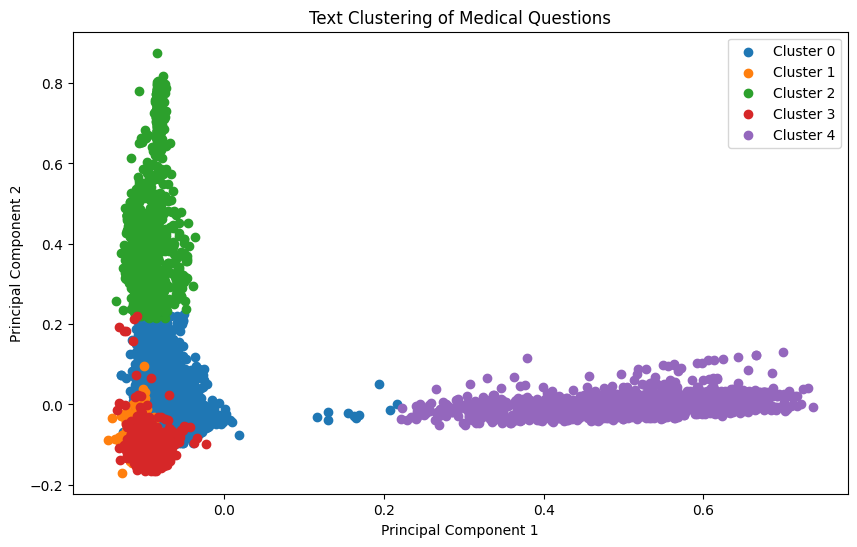

Cluster 0 - Sample Question: What is (are) Congenital muscular dystrophy ?

Cluster 1 - Sample Question: What are the treatments for isolated ectopia lentis ?

Cluster 2 - Sample Question: Is CASK-related intellectual disability inherited ?

Cluster 3 - Sample Question: What is (are) Salivary Gland Cancer ?

Cluster 4 - Sample Question: What are the symptoms of Osteopetrosis autosomal recessive 2 ?



In [31]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Combine 'Question' and 'Answer' columns for clustering
documents = df['Question'].fillna('') + ' ' + df['Answer'].fillna('')

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Apply K-means clustering
num_clusters = 5  # Adjust the number of clusters based on your preference
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Visualize clusters in 2D
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    plt.scatter(X_pca[df['Cluster'] == cluster, 0], X_pca[df['Cluster'] == cluster, 1], label=f'Cluster {cluster}')

plt.title('Text Clustering of Medical Questions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Display sample questions from each cluster
for cluster in range(num_clusters):
    sample_question = df[df['Cluster'] == cluster]['Question'].sample(n=1).values[0]
    print(f"Cluster {cluster} - Sample Question: {sample_question}\n")